<a href="https://colab.research.google.com/github/Kaustavee/codealpha_ABTesting/blob/master/A_B_Testing_Ad_campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'marketing-ab-testing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1660669%2F2724653%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T011350Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2818dd359740ebe3b75bd64e9e10f714a7ac5ef022b93c852d293de5b5afd86723ded0077cc173cb633ffc095e9f77170e39574001fc59f22f83d3b56264222c804b6c57205386931667b492bd202c55d31db5d48824beaf80eec6ed15368ce1f286fd9599e26079ed02293123a95ab2e3f880dfc1b3e021aa46841ecec7782d16ff8dd8ec1d4fd8c24c6222280af02e0115a58ea0f212157c2c1e2b144170629ae949df1559c2ed952b1901dcb47e7ea7399a065599ef3608befef46e987828e9e2608717a5df72f909459b0d79bcce7bd7746357cef7b5c94240e62d09ceb6a1b02dc54ef47ca2f4f1e56701ba8bd7ce635b4feee798efff96aac234ec1cfc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5488727 bytes downloaded
Downloaded and uncompressed: marketing-ab-testing
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-ab-testing/marketing_AB.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")

In [5]:
df.head()  #initial observation of the dataset

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


# QUESTIONS TO BE SOLVED/ENQUIRED FOR A/B TESTING
> The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?

# DATA GIVEN :-
> Index: Row index

> user id: User ID (unique)
> test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement

> converted: If a person bought the product then True, else is False

> total ads: Amount of ads seen by person

> most ads day: Day that the person saw the biggest amount of ads

> most ads hour: Hour of day that the person saw the biggest amount of ads

In [6]:
#user id is a primary key in the relation , therefore it has to be unique, checking for duplicates in the user id field.
df.duplicated(subset = 'user id').sum()

0

In [7]:
# unnamed and user id column are of no use in the given analysis, therefore drop any unnecessary column
df.drop(['Unnamed: 0','user id'], axis = 1, inplace = True)

In [8]:
df.columns

Index(['test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

In [9]:
#check if the categorical variables have appropriate number of levels
df_cat  = df[['test group','converted','most ads day','most ads hour']]
df_cat.nunique()

,0
test group,2
converted,2
most ads day,7
most ads hour,24


In [10]:
#check if the categorical variables have appropriate levels
for i in df_cat.columns:
    print(i.upper(),df_cat[i].unique())

TEST GROUP ['ad' 'psa']
CONVERTED [False  True]
MOST ADS DAY ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
MOST ADS HOUR [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


# UNIVARIATE ANALYSIS

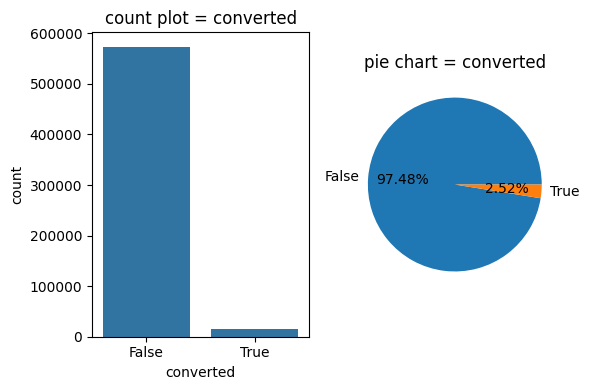

In [11]:
variable = 'converted'
plt.figure(figsize = (6,4))
#counting plot
plt.subplot(1,2,1)
sns.countplot(x=variable,data=df_cat)
plt.title(f'count plot = {variable}')

#pie chart
plt.subplot(1,2,2)
counts = df_cat[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'pie chart = {variable}')

#adjusting the layout
plt.tight_layout()

#show the plots
plt.show()

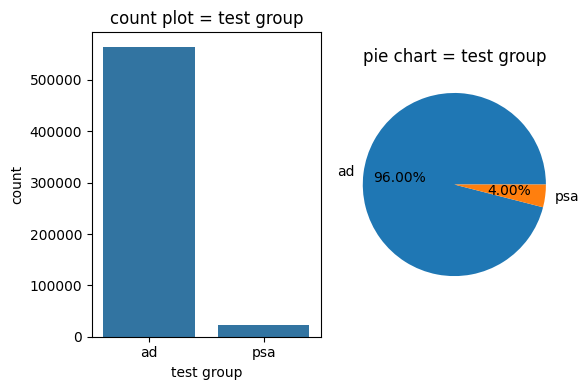

In [12]:
variable = 'test group'
plt.figure(figsize = (6,4))
#counting plot
plt.subplot(1,2,1)
sns.countplot(x=variable,data=df_cat)
plt.title(f'count plot = {variable}')

#pie chart
plt.subplot(1,2,2)
counts = df_cat[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'pie chart = {variable}')

#adjusting the layout
plt.tight_layout()

#show the plots
plt.show()

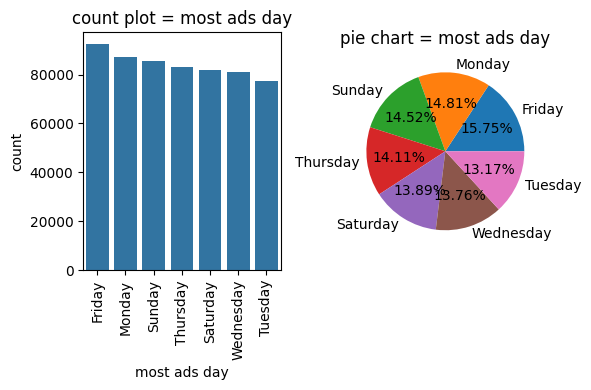

In [13]:
variable = 'most ads day'
plt.figure(figsize = (6,4))
#counting plot
plt.subplot(1,2,1)
sns.countplot(x=variable,data=df_cat,order = df_cat['most ads day'].value_counts().index)
plt.title(f'count plot = {variable}')
plt.xticks(rotation = 90)

#pie chart
plt.subplot(1,2,2)
counts = df_cat[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'pie chart = {variable}')

#adjusting the layout
plt.tight_layout()

#show plot
plt.show()

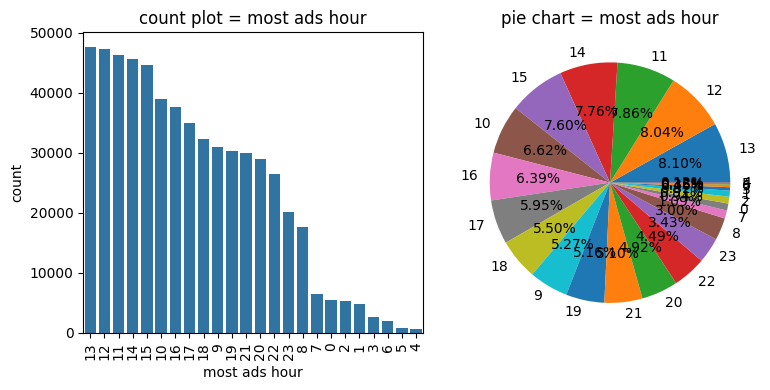

In [14]:
variable = 'most ads hour'
plt.figure(figsize = (8,4))
#counting plot
plt.subplot(1,2,1)
sns.countplot(x=variable,data=df_cat,order = df_cat['most ads hour'].value_counts().index)
plt.title(f'count plot = {variable}')
plt.xticks(rotation = 90)

#pie chart
plt.subplot(1,2,2)
counts = df_cat[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'pie chart = {variable}')

#adjusting the layout
plt.tight_layout()

plt.show()

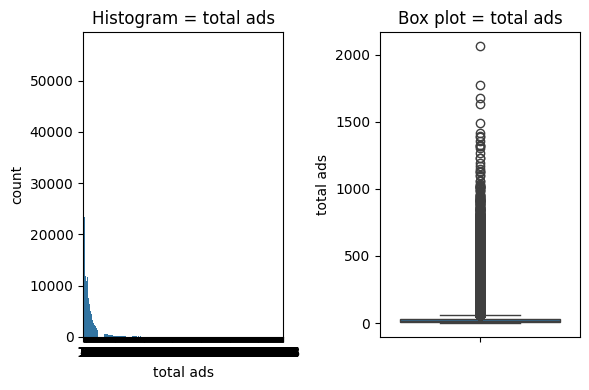

In [15]:
variable = 'total ads'
plt.figure(figsize = (6,4))
#Histogram plot
plt.subplot(1,2,1)
sns.countplot(x=variable,data=df)
plt.title(f'Histogram = {variable}')


#box plot
plt.subplot(1,2,2)
sns.boxplot(y = variable, data = df)
plt.title(f'Box plot = {variable}')

#adjusting the layout
plt.tight_layout()

plt.show()

In [16]:
df['total ads'].describe()

,total ads
count,588101.000000
mean,24.820876
std,43.715181
min,1.000000
25%,4.000000
50%,13.000000
75%,27.000000
max,2065.000000


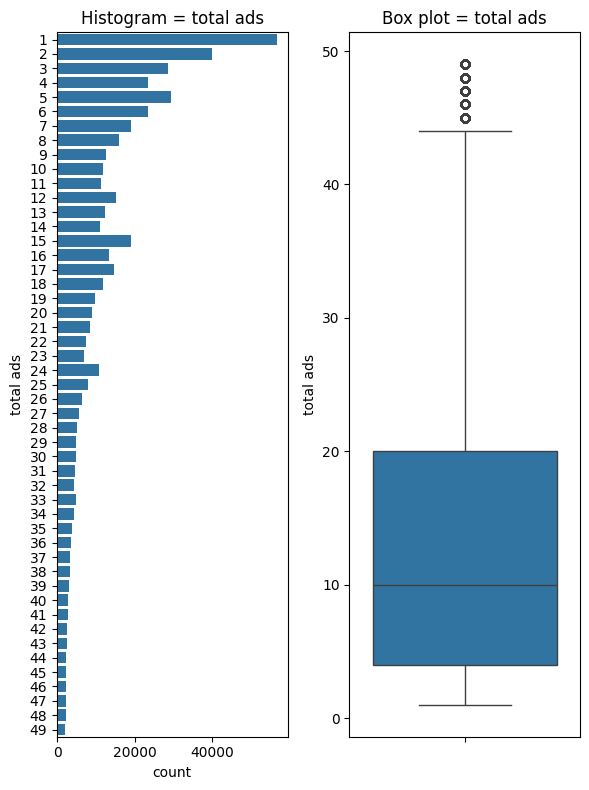

In [17]:
variable = 'total ads'
plt.figure(figsize = (6,8))
#Histogram plot
plt.subplot(1,2,1)
sns.countplot(y=variable,data=df[df['total ads']< 50])
plt.title(f'Histogram = {variable}')
#plt.xticks(rotation = 90)

#box plot
plt.subplot(1,2,2)
sns.boxplot(y = variable, data = df[df['total ads']< 50])
plt.title(f'Box plot = {variable}')

#adjusting the layout
plt.tight_layout()
plt.show()


# BIVARIATE ANALYSIS

In [ ]:
ct_conversion_test_group = pd.crosstab(df['test group'], df['converted'], normalize = 'index')
ct_conversion_test_group

In [ ]:
ct_conversion_test_group.plot.bar(stacked = True)

In [ ]:
ct_conversion_day = pd.crosstab(df['most ads day'], df['converted'], normalize = 'index')
print(ct_conversion_day.sort_values(by = True, ascending = False))
ct_conversion_day.plot.bar(stacked =  True)

In [ ]:
ct_conversion_day = pd.crosstab(df['most ads hour'], df['converted'], normalize = 'index')
print(ct_conversion_day.sort_values(by = True, ascending = False))
ct_conversion_day.plot.bar(stacked =  True)

In [ ]:
sns.boxplot(x = 'converted', y = 'total ads', data = df[df['total ads']<50])

# STATISTICAL TESTS

In [18]:
from scipy.stats import chi2_contingency
alpha = 0.05

for variable in df_cat.columns:
    if variable != 'converted':
        contingency_table = pd.crosstab(df_cat[variable], df_cat['converted'])

        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)

        # Display the merits
        print(f"\n chi squared test for {variable} vs. converted")
        print(f"chi squared value : {chi2}")
        print(f"p-value: {p}")

        # Check for significance
        if p < alpha:
            print(f"the difference in conversion rates for {variable} is statistically significant")
        else:
            print(f"there is no significant difference in conversion across {variable}")


 chi squared test for test group vs. converted
chi squared value : 54.005823883685245
p-value: 1.9989623063390075e-13
the difference in conversion rates for test group is statistically significant

 chi squared test for most ads day vs. converted
chi squared value : 410.0478857936585
p-value: 1.932184379244731e-85
the difference in conversion rates for most ads day is statistically significant

 chi squared test for most ads hour vs. converted
chi squared value : 430.76869230822086
p-value: 8.027629823696771e-77
the difference in conversion rates for most ads hour is statistically significant


In [19]:
df_cat.columns

Index(['test group', 'converted', 'most ads day', 'most ads hour'], dtype='object')

In [20]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
shapiro_stat_true, shapiro_p_value_true = shapiro(df[df['converted'] == True]['total ads'])
shapiro_stat_false, shapiro_p_value_false = shapiro(df[df['converted'] == False]['total ads'])
print(f"shapiro-wilk test for normality true: p-value = {shapiro_p_value_true}")
print(f"shapiro-wilk test for normality false: p-value = {shapiro_p_value_false}")

levene_stat, levene_p_val = levene(df[df['converted']]['total ads'], df[~df['converted']]['total ads'])
print(f"levene test for equality of variances : p-value = {levene_p_val}")



shapiro-wilk test for normality true: p-value = 1.638680987007771e-98
shapiro-wilk test for normality false: p-value = 9.883049430735801e-204
levene test for equality of variances : p-value = 0.0


In [21]:
#correcting the previous tests
alpha = 0.05
if shapiro_p_value_true > alpha and shapiro_p_value_false >alpha and levene_p_val > alpha:
    t_st, t_p_val =ttest_ind(df[df['converted']]['total ads'], df[~df['converted']]['total ads'])
    print(f"independent two sample t-test : p-value ={t_p_val}")
else:
    u_st, u_p_val = mannwhitneyu(df[df['converted']]['total ads'],df[~df['converted']]['total ads'])
    print(f"mannwhitney u test : p-value ={u_p_val}")



mannwhitney u test : p-value =0.0


> **If the Mann-Whitney U test also shows a p-value of 0.0, it indicates a statistically significant difference between the medians of the two groups.

In the context of the data, this means there is strong evidence suggesting that the median number of "total ads" for the "converted" group is significantly different from the median number of "total ads" for the "not converted" group.

**

> # ** THE ADVERTISEMENTS WERE NOT SUCCESFULL IN REACHING OUT TO THE PEOPLE.**